# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS-109A Introduction to Data Science

## Lab 7: Building a Neural Network and Dealing with missing values

**Harvard University**<br/>
**Fall 2018**<br/>
**Instructors:** Pavlos Protopapas and Kevin Rader<br/>
**Lab Instructor:** Eleni Kaxiras<br/>
**Authors:** David Sondak and Pavlos Protopapas

### <font color='red'> PRE-LAB : DO THIS PART BEFORE COMING TO LAB</font>

In [69]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pandas as pd
%matplotlib inline

## Learning Goals
In this lab, we'll revise matrix operations and talk about tensors. We will also talk about handling missing data.

By the end of this lab, you should:

- Be able to think of vectors and arrays as tensors.
- Understand how a simple neural network works and code its functions from scratch.
- Know how to use simple pandas and scikit-learn functions to handle missing values.

### <font color='red'> REVISE: `lab3_prelab` which has array manipulations and function plots.</font>


## Part 1. Tensors and Neural Networks

We can think of tensors as multidimensional arrays of numerical values; their job is to  generalize matrices to multiple dimensions. While tensors first emerged in the 20th century, they have since been applied to numerous other disciplines, including machine learning. Tensor decomposition/factorization can solve, among other, problems in unsupervised learning settings, temporal and multirelational data. When we get to handling images for Convolutional Neural Networks, it's a good idea to have the understanding of tensors of rank 3.

We will use the following naming conventions:

- scalar = just a number = rank 0 tensor  ($a$ ∈ $F$,)
<BR><BR>
- vector = 1D array = rank 1 tensor ( $x = (\;x_1,...,x_i\;)⊤$ ∈ $F^n$ )
<BR><BR>
- matrix = 2D array = rank 2 tensor ( $\textbf{X} = [a_{ij}] ∈ F^{m×n}$ )
<BR><BR>
- 3D array = rank 3 tensor ( $\mathscr{X} =[t_{i,j,k}]∈F^{m×n×l}$ )
<BR><BR>
- $\mathscr{N}$D array = rank $\mathscr{N}$ tensor ( $\mathscr{T} =[t_{i1},...,t_{i\mathscr{N}}]∈F^{n_1×...×n_\mathscr{N}}$ ) 
    

#### Python library for tensors
Machine learning libraries have special functions to handle tensors. Numpy has `numpy.tensordot`. Feel free to read about it: [numpy.tensordot](https://docs.scipy.org/doc/numpy-1.15.1/reference/generated/numpy.tensordot.html), but we will **not be covering it** in class.

#### Tensor indexing
We can create subarrays by fixing some of the given tensor’s indices. We can create a vector by fixing all but one index. A 2D matrix is created when fixing all but two indices. For example, for a third order tensor the vectors are $\mathscr{X}[:,j,k]$ = $\mathscr{X}[j,k]$ (column), $\mathscr{X}[i,:,k]$ = $\mathscr{X}[i,k]$ (row), and $\mathscr{X}[i,j,:]$ = $\mathscr{X}[i,j]$ (tube); the matrices are $\mathscr{X}[:,:,k]$ (frontal), $\mathscr{X}[:,j,:]$ (lateral), $\mathscr{X}[i,:,:]$ (horizontal). 
#### Tensor multiplication
We can multiply one matrix with another as long as the sizes are compatible ((n × m) × (m × p) = n × p), and also multiply an entire matrix by a constant. Numpy `numpy.dot` performs a matrix multiplication which is straightforward when we have 2D or 1D arrays. But what about > 3D arrays? The function will choose according to the matching dimentions but if we want to choose we should use `tensordot`, but, again, we do not need that for this class. 

In this lab we will be doing a lot of array manipulation, including: 
- reshaping arrays, 
- slicing x = x[0, 10:15, 10:15] brings it into a lower rank, reordering. Create some small tensors.  
- matrix multiplication.

### Reese Witherspoon as a rank 3 Tensor

(photo from [Labeled Faces in the Wild](http://vis-www.cs.umass.edu/lfw/person/Reese_Witherspoon.html))

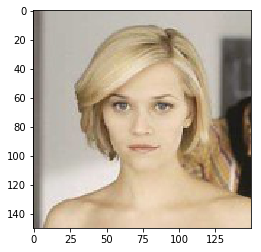

In [41]:
# load and show the image
img = mpimg.imread('Reese_Witherspoon.jpg')
imgplot = plt.imshow(img)

What type is this image? We have a suspicion that it's an array so let's find out its shape.

In [42]:
type(img), img.shape

(numpy.ndarray, (150, 150, 3))

It’s a 24-bit RGB PNG image (height, width, channels) with 8 bits for each of R, G, B. Explore and print the array.

In [ ]:
img[:][0:1][:3]  # selects all rows, 2nd column, and all slices

In [ ]:
img[130]

In [45]:
img[130][100]

array([225, 199, 164], dtype=uint8)

In [46]:
# we are down to a single pixel
img[130][3][0]

123

In [47]:
type(img)

numpy.ndarray

#### Slicing tensors: slice along each axis

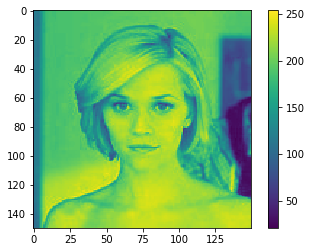

In [48]:
R_img = img[:,:,0]
G_img = img[:,:,1]
B_img = img[:,:,2]
plt.imshow(R_img)
plt.colorbar()

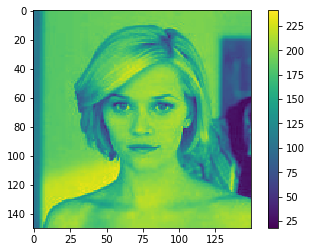

In [49]:
plt.imshow(G_img)
plt.colorbar()

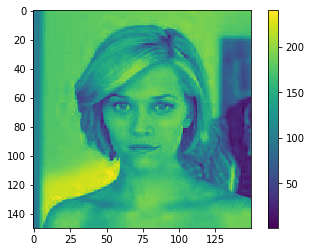

In [50]:
plt.imshow(B_img)
plt.colorbar()

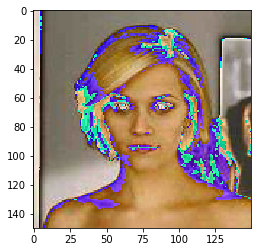

In [51]:
# practice matrix by scalar
img = img * 2
plt.imshow(img)

### Neural Networks 101: Starting with a Single Node

We begin with a single node (also called a neuron).

![perceptron](figs/perceptron.png)

There are some inputs $x$, which get combined into an auxilliary variable $z$.  The auxilliary variable is passed through the activation function $\sigma\left(z\right)$ and the result is the output.

Here is another image showing each step.

![](figs/expanded-perceptron.png)

Notice that the inputs are linearly combined according to some weights $w$ and a bias $b$.  This transformation is also sometimes called an **affine** transformation.  The perceptron transforms the weighted inputs according to the rule of the activation function.  For a single perceptron, the output $y$ is just the output from the perceptron.  The linear transformation and activation of the neuron occurs within a single **layer** of the network (shown in the dotted box).

### Example
The task is to approximate (or learn) a function $f\left(x\right)$ given some input $x$.  For demonstration purposes, the function we will try to learn is a Gaussian function 
\begin{align}
f\left(x\right) = e^{-x^{2}}
\textrm{}
\end{align}

Even though we represent the input $x$ as a vector on the computer, you should think of it as a single input.  For example, we're not passing $x$ and $y$ into the network.

In [52]:
x = np.linspace(-5.0, 5.0, 500) # input points
x[:5]

array([-5.        , -4.97995992, -4.95991984, -4.93987976, -4.91983968])

Let's plot the sigmoid and the tanh to see their difference

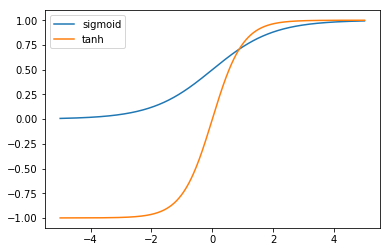

In [53]:
def sigmoid(x):                                        
    return 1 / (1 + np.exp(-x)) # The real function

plt.plot(x, sigmoid(x), label='sigmoid')
plt.plot(x, np.tanh(x), label='tanh')
plt.legend()

To transform a $tanh$ into a $sigmoid$:

\begin{align}
\dfrac{1}{2}+\dfrac{1}{2}\tanh(\dfrac{x-c}{a}) = \dfrac{1}{2}+\dfrac{1}{2}\dfrac{e^{(x-c)/a} - e^{- (x-c)/a}}{e^{(x-c)/a)} + e^{- (x-c)/a}}=\dfrac{1}{1+e^{-2(x-c)/a}} \qquad\text{(1.2)}
\textrm{}
\end{align}
<BR>
($c$ is the threshold, $c$=0 in our case, and $a$ is the sharpness)

Now let's create and plot the dataset for our function

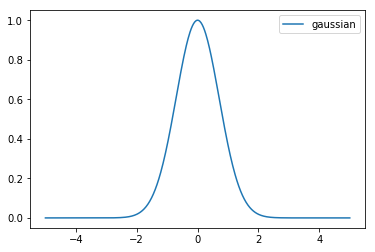

In [54]:
x = np.linspace(-5.0, 5.0, 500) # input points
f = np.exp(-x*x) # The real function

plt.plot(x, f, label='gaussian')
plt.legend()

Let's see what the single-layer, single neuron network give us.  We have a couple of choices to make:
1. We must choose some weights and some biases
2. We must choose an activation function

For now, we will manually specify the weights and biases.

We choose a *sigmoid* activation function $$\sigma\left(x\right) = \dfrac{1}{1 + e^{-z}}.$$  What are the limits $\displaystyle\lim_{z\to\infty}\sigma\left(z\right)$ and $\displaystyle\lim_{z\to-\infty}\sigma\left(z\right)$?  Actually, the sigmoid we have here is called the *logistic* function.  Sigmoids are really a family of functions and the logistic function is just one member in that family.

There are other activation functions as well.  For example:
* Rectified linear unit:  $$\sigma\left(z\right) = \text{max}\left(0, z\right)$$
* Hyperbolic tangent:  $$\sigma\left(z\right) = \tanh\left(z\right)$$

Choosing the correct activation function is a really big deal.  Notice that the activation functions we've mentioned so far have the feature that they "turn on" at some point and "saturate" at some point.

In [55]:
# Manually specify the weight and bias
w = -4.5 # weight
b = 3.0 # bias

# Perceptron output
z = w * x + b # Affine transformation
h = 1.0 / (1.0 + np.exp(-z)) # Sigmoid activation

And now we plot the activation function and the true function.

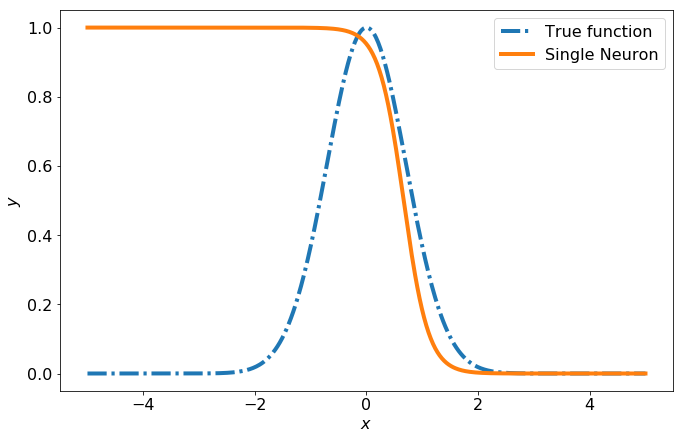

In [56]:
fig, ax = plt.subplots(1,1, figsize=(11,7)) # create axes object

SIZE = 16
# Plot
ax.plot(x, f, ls='-.', lw=4, label=r'True function')
ax.plot(x, h, lw=4, label=r'Single Neuron')

# Create labels (very important!)
ax.set_xlabel('$x$', fontsize=SIZE) # Notice we make the labels big enough to read
ax.set_ylabel('$y$', fontsize=SIZE)

ax.tick_params(labelsize=SIZE) # Make the tick labels big enough to read

ax.legend(fontsize=SIZE, loc=1) # Create a legend and make it big enough to read

The single perceptron simply turns the output on and off at some point, but that's about it.  We see that the neuron is on until about $x=0$ at which point it abruptly turns off.  It's able to get "close" to the true function.  Otherwise, it has nothing in common with the true function.

What do you think will happen if you change $w$ and $b$?

## Multiple Perceptrons in a Single Layer
It appears that a single neuron is somewhat limited in what it can accomplish.  What if we expand the number of nodes/neurons in our network?  We have two obvious choices here.  One option is to add depth to the network by putting layers next to each other.  The other option is to stack neurons on top of each other in the same layer.  Now the network has some width, but is still only one layer deep.

The following figure shows a single-layer network with two nodes in one layer.

![](figs/multiple-perceptrons.png)

#### Some observations
1. We still have a single input in this case.  Note that this is not necessary in general.  We're just keeping things simple with a single input for now. If we have more inputs we will have a matrix for $X$.
2. Each node (or neuron) has a weight and bias associated with it.  An affine transformation is performed for each node.
3. Both nodes use the same activation function form $\sigma\left(\cdot\right)$ on their respective inputs.
4. The outputs of the nodes must be combined to give the overall output of the network.  There are a variety of ways of accomplishing this.  In the current example, we just take a linear combination of the node outputs to produce the actual prediction.  Notice that now we have weights and biases at the output too.

## Part 2. Handling Missing Variables

#### Imputation in pandas

Pandas has chosen to use the floating point NaN internally to denote missing data and that was largely for simplicity and performance reasons. The library will also recognize the Python `None` as “missing” or “not available” or “NA”. When doing descriptive statistics, pandas excludes missing values by default. 

In [90]:
s = pd.Series([0, 1, np.nan, 4, 6, 8, 15, 23, 25, np.nan])
s

0     0.0
1     1.0
2     NaN
3     4.0
4     6.0
5     8.0
6    15.0
7    23.0
8    25.0
9     NaN
dtype: float64

In [91]:
# look for missing values
s.isna() # or s.isnull()

0    False
1    False
2     True
3    False
4    False
5    False
6    False
7    False
8    False
9     True
dtype: bool

pandas can [interpolate](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.interpolate.html#pandas.DataFrame.interpolate) according to different methods.

In [92]:
# how many?
s.isna().sum()

2

In [93]:
s.isnull().sum()

2